## Importing required libraries

In [0]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score, log_loss
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier as kNN

import dlib
import cv2
import os

from keras.models import Model, Sequential
from keras.layers import Flatten, Dense, Activation, Dropout
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras import backend as K

## Reading train and test data

In [0]:
train_images_path = './data/train/images'
test_images_path = './data/test/images'
train_csv_path = './data/train/y_train.csv'
test_csv_path = './data/test/y_test.csv'

In [55]:
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

print('Shape of train data',train_df.shape)
print('Shape of test data',test_df.shape)

Shape of train data (661, 2)
Shape of test data (808, 2)


## Exploratory Data analysis of train data and test data

In [56]:
train_df.head()

,filename,class_id
0,0.jpg,James_Blake
1,1.jpg,Carlos_Moya
2,10.jpg,Jeremy_Greenstock
3,100.jpg,Richard_Myers
4,101.jpg,Pete_Sampras


In [57]:
test_df.head()

,filename,class_id
0,1000.jpg,Silvio_Berlusconi
1,1001.jpg,Jennifer_Aniston
2,1002.jpg,Michael_Bloomberg
3,1003.jpg,Andre_Agassi
4,1004.jpg,Colin_Powell


### Label encoding the classes

In [0]:
le = LabelEncoder()
train_label = le.fit_transform(train_df['class_id'])
test_label = le.transform(test_df['class_id'])
train_df['label'] = train_label
test_df['label'] = test_label

In [59]:
train_df.head()

,filename,class_id,label
0,0.jpg,James_Blake,40
1,1.jpg,Carlos_Moya,15
2,10.jpg,Jeremy_Greenstock,46
3,100.jpg,Richard_Myers,86
4,101.jpg,Pete_Sampras,81


### Number of unique people

In [60]:
print('Number of unique people in tarin data', len(np.unique(train_df['label'])))
print('Number of unique people in test data', len(np.unique(test_df['label'])))

Number of unique people in tarin data 107
Number of unique people in test data 106


### Number of images per person

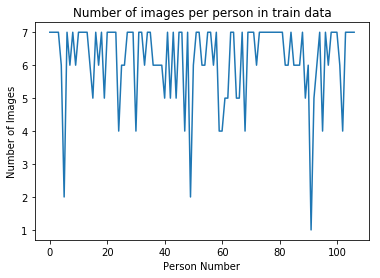

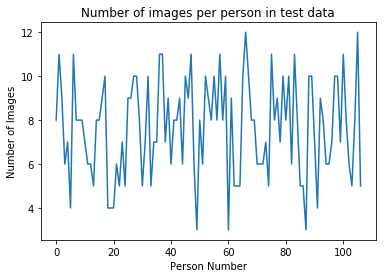

In [61]:
unique, counts = np.unique(train_df['label'], return_counts = True)
plt.plot(unique, counts)
plt.xlabel('Person Number')
plt.ylabel('Number of Images')
plt.title('Number of images per person in train data')
plt.show()


unique, counts = np.unique(test_df['label'], return_counts = True)
plt.plot(unique, counts)
plt.xlabel('Person Number')
plt.ylabel('Number of Images')
plt.title('Number of images per person in test data')
plt.show()

There is atleast 1 image per person and there are at max 7 images per person in tarin data.
The Number of images per person in test data vary from 1 to 12.

## Displaying some images from train data

Image path ./data/train/images/0.jpg
Shape of image (242, 242, 3)


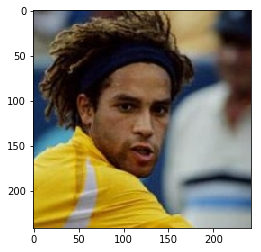

Image path ./data/train/images/1.jpg
Shape of image (244, 243, 3)


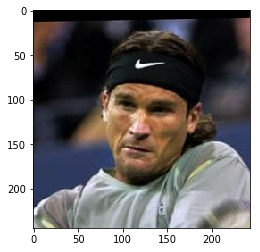

Image path ./data/train/images/10.jpg
Shape of image (241, 238, 3)


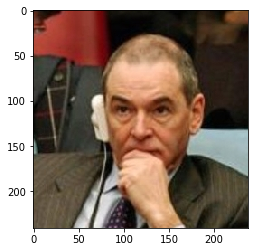

Image path ./data/train/images/100.jpg
Shape of image (245, 246, 3)


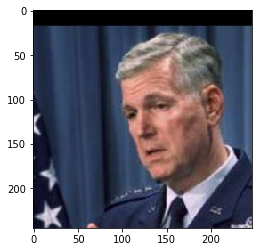

In [62]:
filename = ['0.jpg', '1.jpg', '10.jpg', '100.jpg']
for file in filename:
    image_path = os.path.join(train_images_path, file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print('Image path', image_path)
    print('Shape of image', image.shape)
    plt.imshow(image)
    plt.show()

## Detecting the face part and resize the image

### Dlib face detector

In [0]:
detector = dlib.get_frontal_face_detector()
def detect_face(img): 
    dets = detector(img)
    if len(dets) == 0:
        return None
    for d in dets:
        top = d.top()
        bottom = d.bottom()
        left = d.left()
        right = d.right()
        height = bottom - top
        width = right - left

        scale = 0.2
        top = max(0, int(top - height*scale))
        bottom = min(img.shape[0], int(bottom + height*scale))
        left = max(0, int(left - width*scale))
        right = min(img.shape[1], int(right + width*scale))
        if top >= 0 and left >= 0:
            cropped = img[top:bottom, left:right, :]
            cropped = cv2.resize(cropped, (224, 224))
            break
        
    return cropped

Image path ./data/train/images/0.jpg
Shape of detected_face (224, 224, 3)


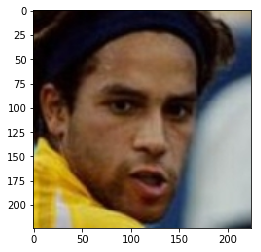

Image path ./data/train/images/1.jpg
Shape of detected_face (224, 224, 3)


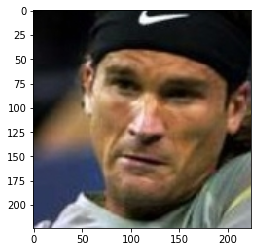

Image path ./data/train/images/10.jpg
Shape of detected_face (224, 224, 3)


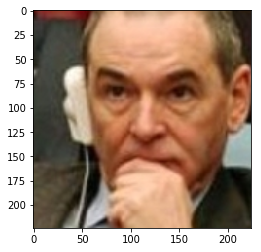

Image path ./data/train/images/100.jpg
Shape of detected_face (224, 224, 3)


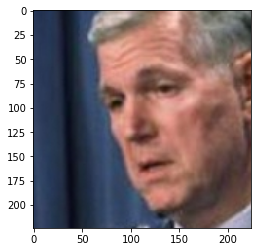

In [79]:
filename = ['0.jpg', '1.jpg', '10.jpg', '100.jpg']
for file in filename:
    image_path = os.path.join(train_images_path, file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    detected_face = detect_face(image)
    print('Image path', image_path)
    if detected_face is None:
        print('No face detected')
    else:
        print('Shape of detected_face', detected_face.shape)
        plt.imshow(detected_face)
        plt.show()

## Defining the VGG Face model

Model is taken from :- https://sefiks.com/2018/08/06/deep-face-recognition-with-keras/

In [0]:
def VGG_Face():
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    
    return model

In [65]:
model = VGG_Face()
model.load_weights('vgg_face_weights.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_40 (ZeroPaddi (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_41 (ZeroPaddi (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_42 (ZeroPaddi (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 112, 112, 128)     73856     
__________

## Creating Image encodings using the above pretrain model

In [66]:
print('The layer from which we will create image encodings is',model.layers[-7].output)

The layer from which we will create image encodings is Tensor("conv2d_62/Relu:0", shape=(?, 1, 1, 4096), dtype=float32)


In [0]:
output = model.layers[-7].output
feature_extraction_model = Model(model.input, output)

X_train = []                                                                    #list to hold all encodings of faces
Y_train = []                                                                    #list to hold labels

for index, row in train_df.iterrows():
    image_name = row['filename']
    label = row['label']

    image_path = os.path.join(train_images_path, image_name)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    detected_face = detect_face(image)
    if detected_face is not None:                                               #ignoring the images in which face is not detected
        detected_face = np.expand_dims(detected_face, axis = 0)                 #change shape from 224*224*3 to 1*224*224*3
        encoding = feature_extraction_model.predict(detected_face)              #extracting the features
        encoding = encoding.reshape(4096)                                       #reshape to 4096 vector
        X_train.append(encoding)                                                #append encoding to X_train
        Y_train.append(label)                                                   #append label to Y_train
        
        
X_train = np.array(X_train)       

In [68]:
print('Shape of Train data is ',X_train.shape)

Shape of Train data is  (660, 4096)


## Training KNN Classifier on image encodings

In [76]:
clf = kNN(n_neighbors = 5, weights = 'distance')
clf.fit(X_train, Y_train)

pred_tr = clf.predict(X_train)
print('Accuracy on train data', accuracy_score(Y_train, pred_tr))

Accuracy on train data 1.0


### Predictions on test data

In [0]:
pred_test = []
Y_test = []

for index, row in test_df.iterrows():
    image_name = row['filename']
    label = row['label']

    image_path = os.path.join(test_images_path, image_name)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    detected_face = detect_face(image)
    if detected_face is not None:                                               #ignoring the images in which face is not detected
        detected_face = np.expand_dims(detected_face, axis = 0)                 #change shape from 224*224*3 to 1*224*224*3
        encoding = feature_extraction_model.predict(detected_face)              #extracting the features
        encoding = encoding.reshape(4096)                                       #reshape to 4096 vector
        pred = clf.predict([encoding])                                          #predicting using above classifier
        pred_test.append(pred[0])                                               
        Y_test.append(label)

In [78]:
print('Accuracy on test data', accuracy_score(Y_test, pred_test))

Accuracy on test data 0.9639303482587065


## Training Logistic Regression Classifier on image encodings

### Predictions on train data

In [71]:
clf = SGDClassifier(alpha = 0.0001, penalty = 'l1', loss = 'log')
clf.fit(X_train, Y_train)

pred_tr = clf.predict(X_train)
print('Accuracy on train data', accuracy_score(Y_train, pred_tr))

Accuracy on train data 1.0


### Predictions on test data

In [0]:
pred_test = []
Y_test = []

for index, row in test_df.iterrows():
    image_name = row['filename']
    label = row['label']

    image_path = os.path.join(test_images_path, image_name)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    detected_face = detect_face(image)
    if detected_face is not None:                                               #ignoring the images in which face is not detected
        detected_face = np.expand_dims(detected_face, axis = 0)                 #change shape from 224*224*3 to 1*224*224*3
        encoding = feature_extraction_model.predict(detected_face)              #extracting the features
        encoding = encoding.reshape(4096)                                       #reshape to 4096 vector
        pred = clf.predict([encoding])                                          #predicting using above classifier
        pred_test.append(pred[0])                                               
        Y_test.append(label)

In [74]:
print('Accuracy on test data', accuracy_score(Y_test, pred_test))

Accuracy on test data 0.9166666666666666


## Steps followed

1. Importing required libraries
2. Reading csv files for train and test set and encoding the classes using label encoder.
3. Defining a pre-trained model (VGG Face) and laoding weights
4. For Training data
 - Detecting face from each image and cropping the face part
 - Creating face encodings of 4096 shape using the above pretrained model
 - Training a Machine Learning classifier on above encodings
       
5. Similarly for test data
  - Detecting face from each image and cropping the face part
 - Creating face encodings of 4096 shape using the above pretrained model
 - Classifying the person using the above Machine Learning classifier